In [26]:
# CELL 1: Imports
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.ndimage import center_of_mass, label, binary_dilation
from nilearn import plotting
import pandas as pd

print("✓ Imports loaded")

✓ Imports loaded


In [3]:
# CELL 2: Paths and Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {
        'code': 'UD', 
        'sessions': ['01', '02', '03', '05', '06'],
        'hemi': 'l'
    },
    'sub-021': {
        'code': 'TC', 
        'sessions': ['01', '02', '03'],
        'hemi': 'r'
    }
}

# Cope mapping (condition > scramble contrasts)
COPE_MAP = {
    'face': 10,
    'word': 12,
    'object': 3,
    'house': 11
}

print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Subjects: {list(SUBJECTS.keys())}")

Base directory: /user_data/csimmon2/long_pt
Output directory: /user_data/csimmon2/long_pt/analyses/rsa_corrected
Subjects: ['sub-004', 'sub-021']


In [22]:
# Category-specific anatomical search regions
CATEGORY_PARCELS = {
    'face': ['fusiform'],
    'word': ['fusiform', 'inferiortemporal'],
    'object': ['lateraloccipital'],
    'house': ['parahippocampal', 'lingual', 'isthmuscingulate']
}

# Create category-specific masks
def create_category_specific_masks(subject_id, dilation_iterations=1):
    """
    Create separate anatomical search masks for each category
    More precise than merged VOTC
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    roi_dir = BASE_DIR / subject_id / 'ses-01' / 'ROIs'
    
    print(f"\n{'='*70}")
    print(f"{code} - Category-Specific Masks (1x dilation)")
    print(f"{'='*70}")
    
    from scipy.ndimage import binary_dilation
    
    category_masks = {}
    
    for category, parcel_list in CATEGORY_PARCELS.items():
        print(f"\n{category.upper()}:")
        
        combined = None
        ref_img = None
        
        for parcel in parcel_list:
            parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
            
            if not parcel_file.exists():
                print(f"  ⚠️  Missing: {parcel}")
                continue
            
            img = nib.load(parcel_file)
            mask = img.get_fdata() > 0
            n_vox = np.sum(mask)
            print(f"  {parcel:20s}: {n_vox:6d} voxels")
            
            if combined is None:
                combined = mask
                ref_img = img
            else:
                combined = combined | mask
        
        if combined is None:
            print(f"  ❌ No parcels found")
            continue
        
        print(f"  Combined (before dilation): {np.sum(combined):6d} voxels")
        
        # Single dilation
        combined = binary_dilation(combined, iterations=dilation_iterations)
        print(f"  After 1x dilation:          {np.sum(combined):6d} voxels")
        
        # Save
        output_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
        mask_img = nib.Nifti1Image(combined.astype(np.float32), ref_img.affine)
        nib.save(mask_img, output_file)
        
        category_masks[category] = output_file
        print(f"  ✓ Saved: {output_file.name}")
    
    return category_masks

# Create for both subjects
category_masks = {}
for subj in ['sub-004', 'sub-021']:
    category_masks[subj] = create_category_specific_masks(subj, dilation_iterations=1)

print("\n" + "="*70)
print("CATEGORY-SPECIFIC MASKS CREATED")
print("="*70)


UD - Category-Specific Masks (1x dilation)

FACE:
  fusiform            :  12134 voxels
  Combined (before dilation):  12134 voxels
  After 1x dilation:           19331 voxels
  ✓ Saved: l_face_searchmask.nii.gz

WORD:
  fusiform            :  12134 voxels
  inferiortemporal    :  14609 voxels
  Combined (before dilation):  26743 voxels
  After 1x dilation:           40129 voxels
  ✓ Saved: l_word_searchmask.nii.gz

OBJECT:
  lateraloccipital    :  15770 voxels
  Combined (before dilation):  15770 voxels
  After 1x dilation:           25843 voxels
  ✓ Saved: l_object_searchmask.nii.gz

HOUSE:
  parahippocampal     :   1847 voxels
  lingual             :   9576 voxels
  isthmuscingulate    :   3317 voxels
  Combined (before dilation):  14740 voxels
  After 1x dilation:           24507 voxels
  ✓ Saved: l_house_searchmask.nii.gz

TC - Category-Specific Masks (1x dilation)

FACE:
  fusiform            :   8484 voxels
  Combined (before dilation):   8484 voxels
  After 1x dilation:       

In [24]:
# Test coverage with new category-specific masks
def test_final_category_coverage(subject_id, threshold_z=3.0):
    """Test coverage with updated house mask (PPA + lingual + isthmus)"""
    code = SUBJECTS[subject_id]['code']
    
    print(f"\n{code} - Final Category-Specific Coverage (z>{threshold_z}):")
    print(f"{'Category':<10} {'Mask Size':>12} {'Largest Cluster':>16} {'Status'}")
    print("-"*70)
    
    for cat, cope in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        if cat not in category_masks[subject_id]:
            continue
        
        mask_file = category_masks[subject_id][cat]
        mask = nib.load(mask_file).get_fdata() > 0
        
        cope_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                    'HighLevel.gfeat' / f'cope{cope}.feat' / 'stats' / 'zstat1.nii.gz'
        zstat = nib.load(cope_file).get_fdata()
        
        in_mask = (zstat > threshold_z) & mask
        
        from scipy.ndimage import label
        labeled, n = label(in_mask)
        largest = max([np.sum(labeled == i) for i in range(1, n+1)]) if n > 0 else 0
        peak_z = zstat[in_mask].max() if largest > 0 else 0
        
        if largest >= 300:
            status = "✓✓ EXCELLENT"
        elif largest >= 100:
            status = "✓  GOOD"
        elif largest >= 50:
            status = "⚠️  WEAK"
        else:
            status = "❌ TOO SMALL"
        
        print(f"{cat:<10} {np.sum(mask):>12} {largest:>10} vox   {status}  (peak z={peak_z:.1f})")

# Test both subjects
for subj in ['sub-004', 'sub-021']:
    test_final_category_coverage(subj, threshold_z=3.0)

print("\n" + "="*70)
print("Ready to extract functional ROIs with these masks!")
print("="*70)


UD - Final Category-Specific Coverage (z>3.0):
Category      Mask Size  Largest Cluster Status
----------------------------------------------------------------------
face              19331        391 vox   ✓✓ EXCELLENT  (peak z=4.1)
word              40129         61 vox   ⚠️  WEAK  (peak z=5.1)
object            25843        255 vox   ✓  GOOD  (peak z=4.6)
house             24507         88 vox   ⚠️  WEAK  (peak z=4.4)

TC - Final Category-Specific Coverage (z>3.0):
Category      Mask Size  Largest Cluster Status
----------------------------------------------------------------------
face              13736       6386 vox   ✓✓ EXCELLENT  (peak z=17.3)
word              29532        619 vox   ✓✓ EXCELLENT  (peak z=7.6)
object            21271      10772 vox   ✓✓ EXCELLENT  (peak z=12.5)
house             17288        917 vox   ✓✓ EXCELLENT  (peak z=6.1)

Ready to extract functional ROIs with these masks!


In [ ]:
# Complete Golarai Extraction with Category-Specific Masks
from scipy.ndimage import label, center_of_mass

def extract_functional_rois_final(subject_id, threshold_z=3.0):
    """
    Extract functional cluster ROIs across all sessions
    Using category-specific anatomical masks
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    sessions = SUBJECTS[subject_id]['sessions']
    
    print(f"\n{'='*70}")
    print(f"{code} - Functional Clusters (category-specific masks, z>{threshold_z})")
    print(f"{'='*70}")
    
    all_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        print(f"\n{category.upper()}:")
        all_results[category] = {}
        
        # Load category-specific mask
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  Mask not found")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:  # Minimum cluster size
                print(f"  ses-{session}: <50 voxels (skipped)")
                continue
            
            # Largest cluster
            labeled, n = label(suprathresh)
            sizes = [(labeled == i).sum() for i in range(1, n+1)]
            largest_idx = np.argmax(sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            # Metrics
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            all_results[category][session] = {
                'n_voxels': sizes[largest_idx-1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
            
            print(f"  ses-{session}: {sizes[largest_idx-1]:4d} voxels, peak z={peak_z:.2f}")
    
    return all_results


def extract_concentric_spheres_final(subject_id, functional_results, radii=[3, 6, 9]):
    """
    Create concentric spheres at ses-01 peaks
    Measure selectivity across sessions
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    sessions = SUBJECTS[subject_id]['sessions']
    
    # Load anatomy for coordinate system
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    
    print(f"\n{'='*70}")
    print(f"{code} - Concentric Spheres (r={radii}mm)")
    print(f"{'='*70}")
    
    sphere_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        
        # Check if category exists in ses-01
        if category not in functional_results or '01' not in functional_results[category]:
            print(f"\n{category.upper()}: No ses-01 peak, skipping")
            continue
        
        peak = functional_results[category]['01']['centroid']
        print(f"\n{category.upper()}: Peak at {peak}")
        
        # Create sphere masks
        brain_shape = ref_img.shape
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]),
            np.arange(brain_shape[1]),
            np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_masks = {}
        for r in radii:
            mask_3d = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= r]
            for coord in within:
                mask_3d[coord[0], coord[1], coord[2]] = True
            sphere_masks[r] = mask_3d
            print(f"  {r}mm sphere: {np.sum(sphere_masks[r])} voxels")
        
        # Measure selectivity across sessions
        selectivity = {r: {} for r in radii}
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            
            for r in radii:
                mean_z = zstat[sphere_masks[r]].mean()
                selectivity[r][session] = mean_z
        
        # Print trajectory
        print(f"  Selectivity trajectory:")
        for r in radii:
            if r in selectivity and len(selectivity[r]) > 0:
                vals = [selectivity[r][s] for s in sessions if s in selectivity[r]]
                print(f"    {r}mm: {' → '.join([f'{v:.2f}' for v in vals])}")
        
        sphere_results[category] = {
            'peak': peak,
            'selectivity': selectivity
        }
    
    return sphere_results


# EXTRACT BOTH APPROACHES
print("\n" + "="*70)
print("EXTRACTING FUNCTIONAL ROIs - FINAL VERSION")
print("="*70)

golarai_functional_final = {}
golarai_spheres_final = {}

for subj in ['sub-004', 'sub-021']:
    golarai_functional_final[subj] = extract_functional_rois_final(subj, threshold_z=3.0)
    golarai_spheres_final[subj] = extract_concentric_spheres_final(
        subj, golarai_functional_final[subj], radii=[3, 6, 9]
    )

print("\n✓ Final ROI extraction complete!")

In [27]:
# CELL: Calculate peak drift (useful metric)
def calculate_peak_drift(functional_results):
    """Calculate total drift for each category"""
    print("\nPeak Movement Summary:")
    print(f"{'Subject':<8} {'Category':<8} {'Total Drift (mm)':<18} {'Sessions'}")
    print("-"*70)
    
    for subj in ['sub-004', 'sub-021']:
        code = SUBJECTS[subj]['code']
        for cat in ['face', 'word', 'object', 'house']:
            if cat not in functional_results[subj]:
                continue
            sessions = sorted(functional_results[subj][cat].keys())
            if len(sessions) < 2:
                continue
            
            first = functional_results[subj][cat][sessions[0]]['centroid']
            last = functional_results[subj][cat][sessions[-1]]['centroid']
            drift = np.linalg.norm(last - first)
            
            print(f"{code:<8} {cat:<8} {drift:>10.1f} mm        {', '.join(sessions)}")

calculate_peak_drift(golarai_functional_final)


Peak Movement Summary:
Subject  Category Total Drift (mm)   Sessions
----------------------------------------------------------------------
UD       face           11.2 mm        01, 02, 03, 05, 06
UD       word           42.1 mm        01, 02, 03, 05, 06
UD       object          5.5 mm        01, 02, 03, 05, 06
UD       house           7.5 mm        01, 02, 03, 05, 06
TC       face            1.6 mm        01, 02, 03
TC       word           12.2 mm        01, 02, 03
TC       object          2.0 mm        01, 02, 03
TC       house           2.2 mm        01, 02, 03


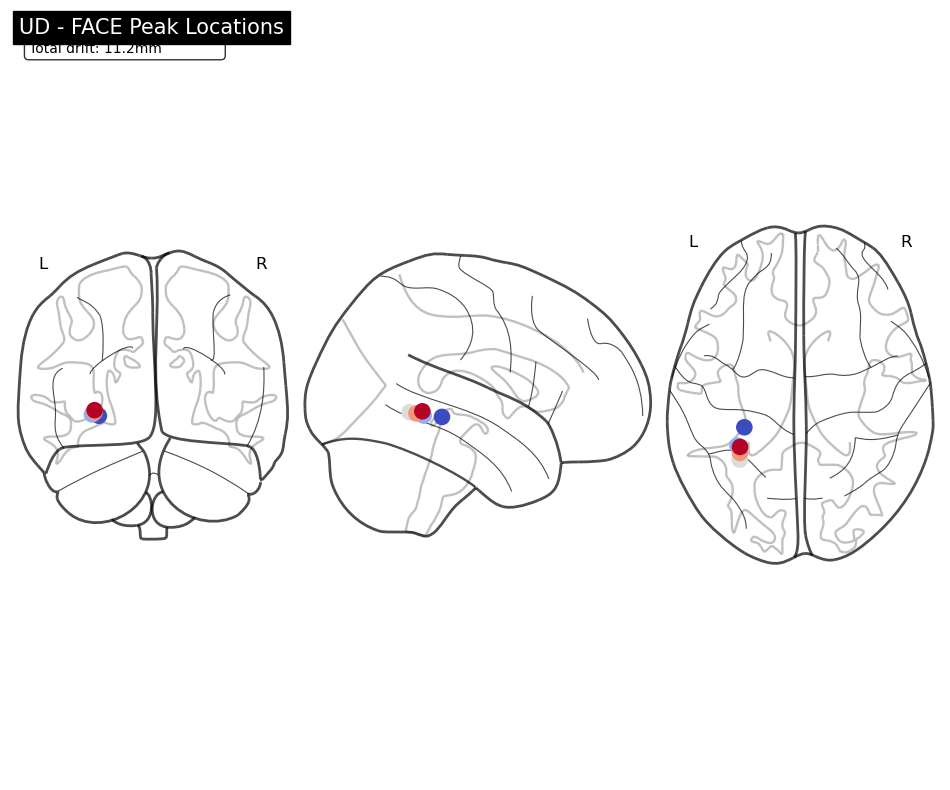

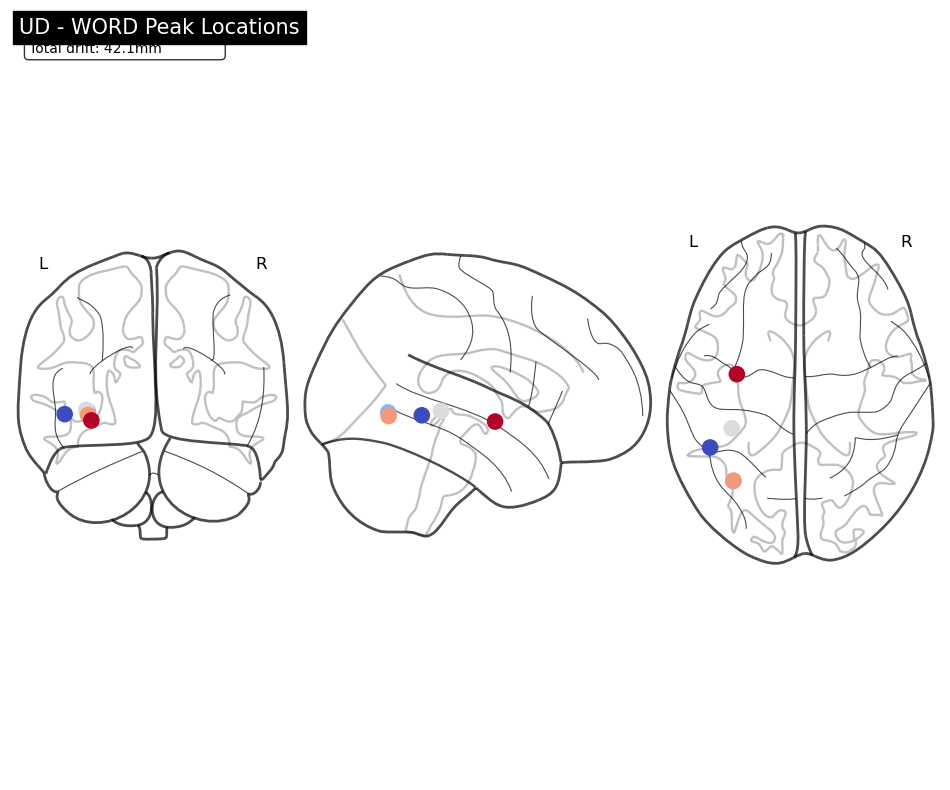

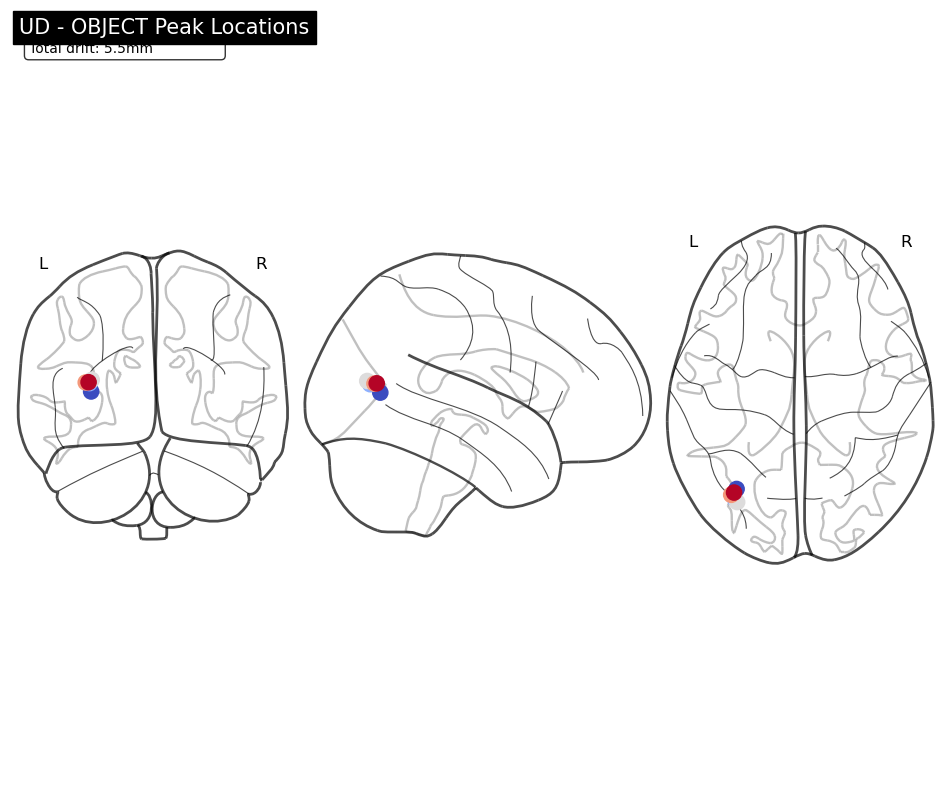

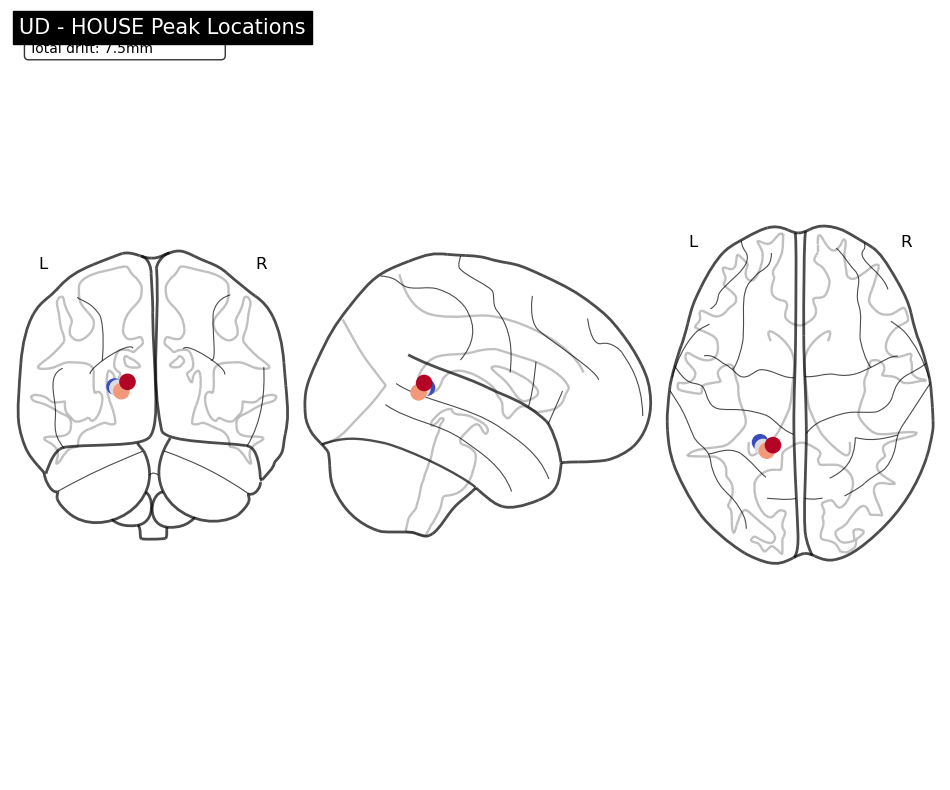

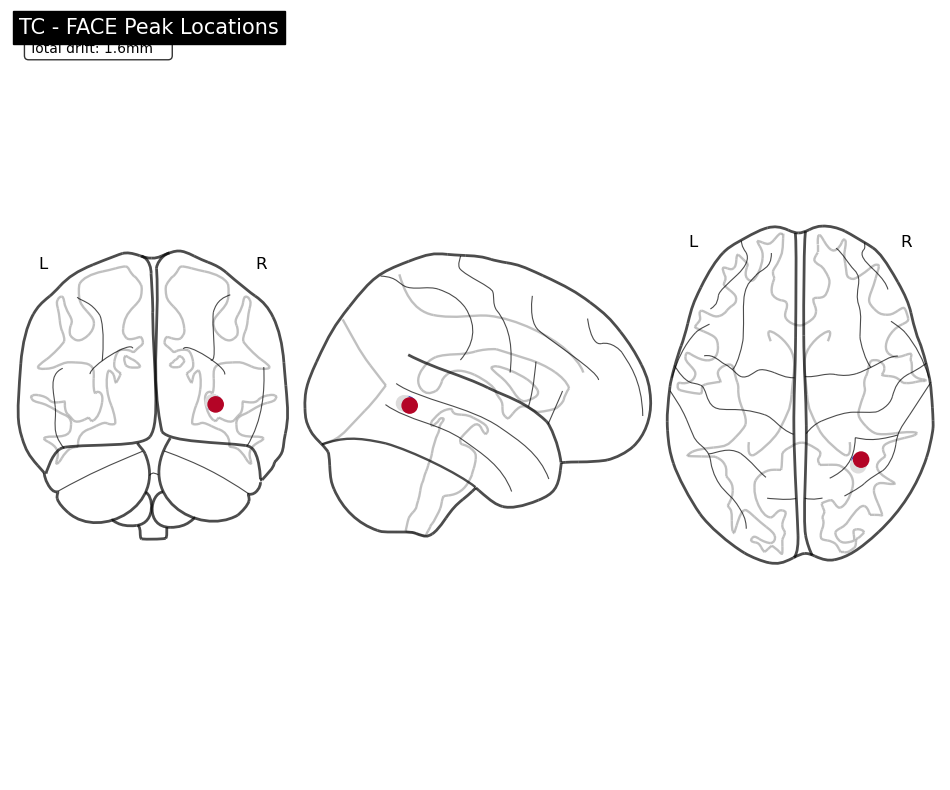

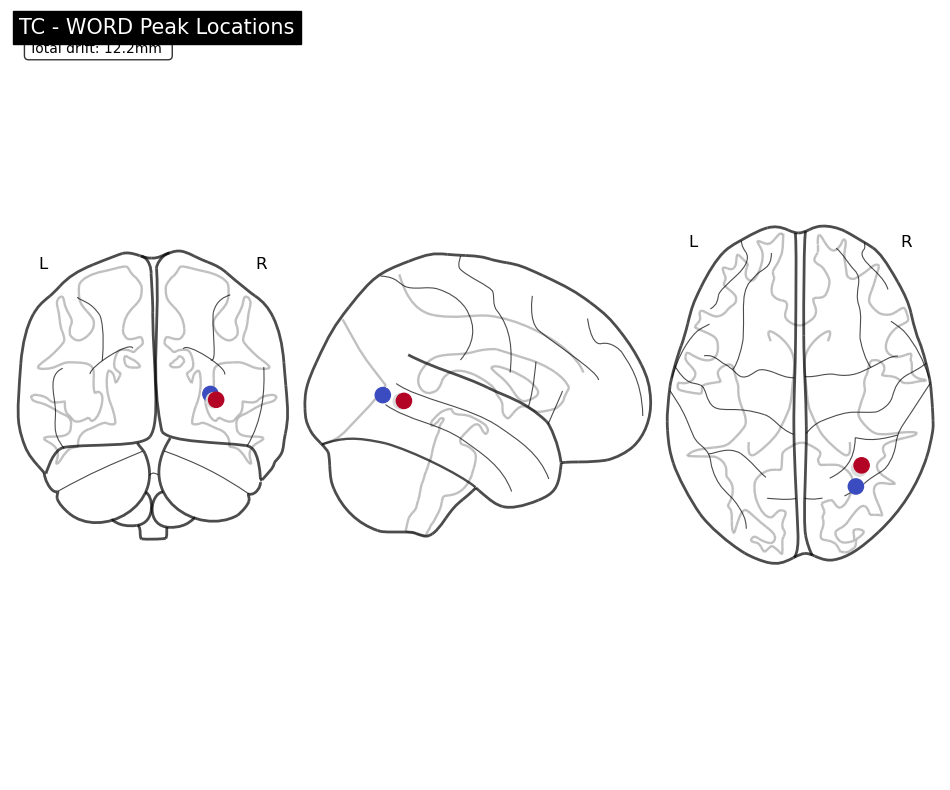

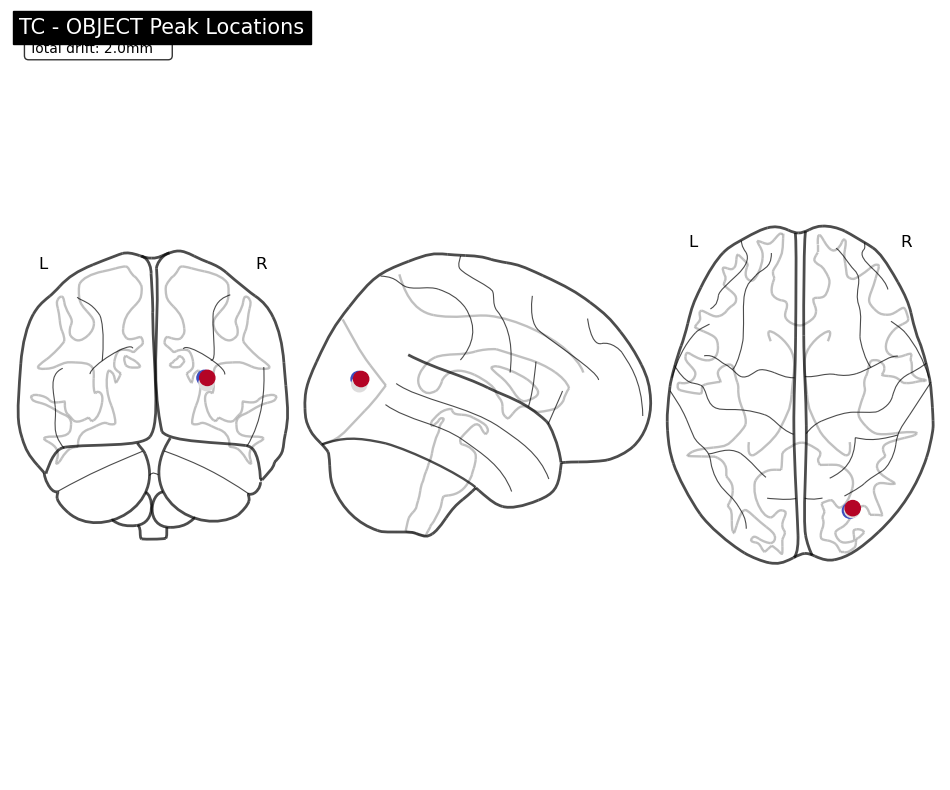

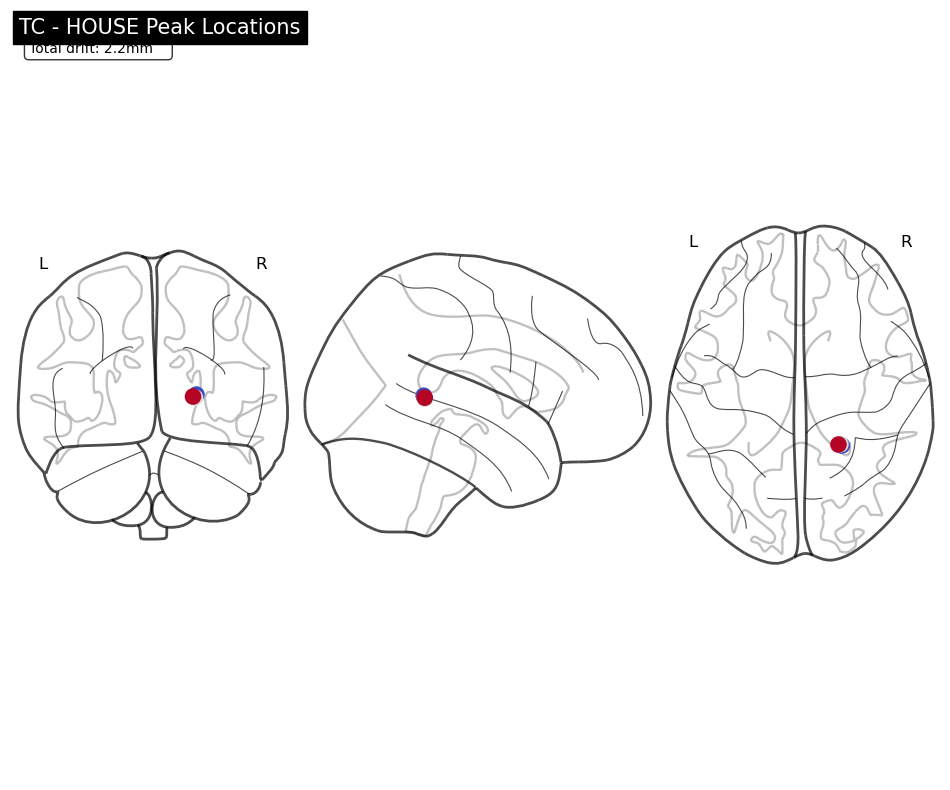

In [28]:
# CELL: Visualize functional trajectories on glass brains
from nilearn import plotting

def visualize_trajectories_final(subject_id, functional_results):
    """Show peak locations across sessions (no connecting lines)"""
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    for category in ['face', 'word', 'object', 'house']:
        if category not in functional_results[subject_id]:
            continue
        
        # Collect centroids
        centroids = []
        valid_sessions = []
        for s in sessions:
            if s in functional_results[subject_id][category]:
                centroids.append(functional_results[subject_id][category][s]['centroid'])
                valid_sessions.append(s)
        
        if len(centroids) == 0:
            continue
        
        centroids = np.array(centroids)
        
        # NO LINES - just dots
        adjacency = np.zeros((len(centroids), len(centroids)))
        
        cmap = plt.cm.coolwarm
        colors = [cmap(i/(len(centroids)-1)) if len(centroids)>1 else cmap(0) 
                  for i in range(len(centroids))]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        plotting.plot_connectome(adjacency, centroids, node_color=colors,
                                node_size=120, axes=ax, colorbar=False,
                                title=f'{code} - {category.upper()} Peak Locations')
        
        # Drift info
        total_drift = np.linalg.norm(centroids[-1] - centroids[0]) if len(centroids) > 1 else 0
        info = f"Sessions: {', '.join(valid_sessions)}\nTotal drift: {total_drift:.1f}mm"
        
        ax.text(0.02, 0.98, info, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.savefig(OUTPUT_DIR / f'{code}_{category}_trajectory.png', dpi=300, bbox_inches='tight')
        plt.show()

# Visualize both subjects
for subj in ['sub-004', 'sub-021']:
    visualize_trajectories_final(subj, golarai_functional_final)

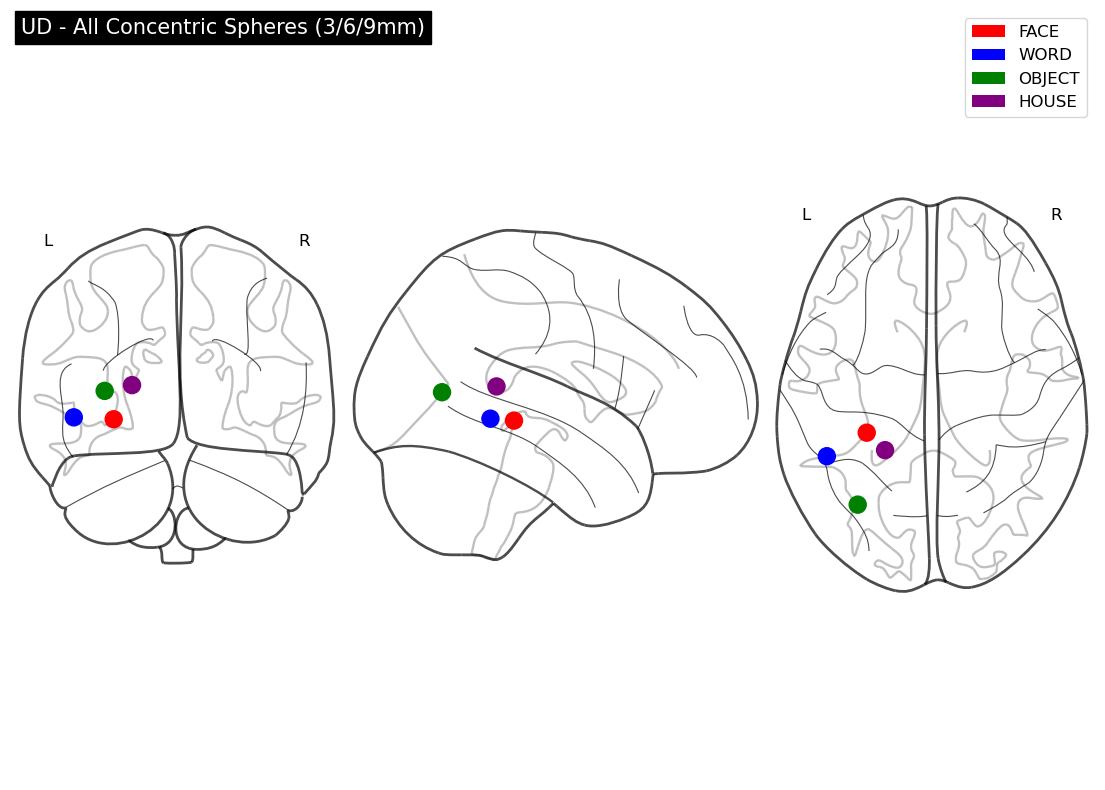

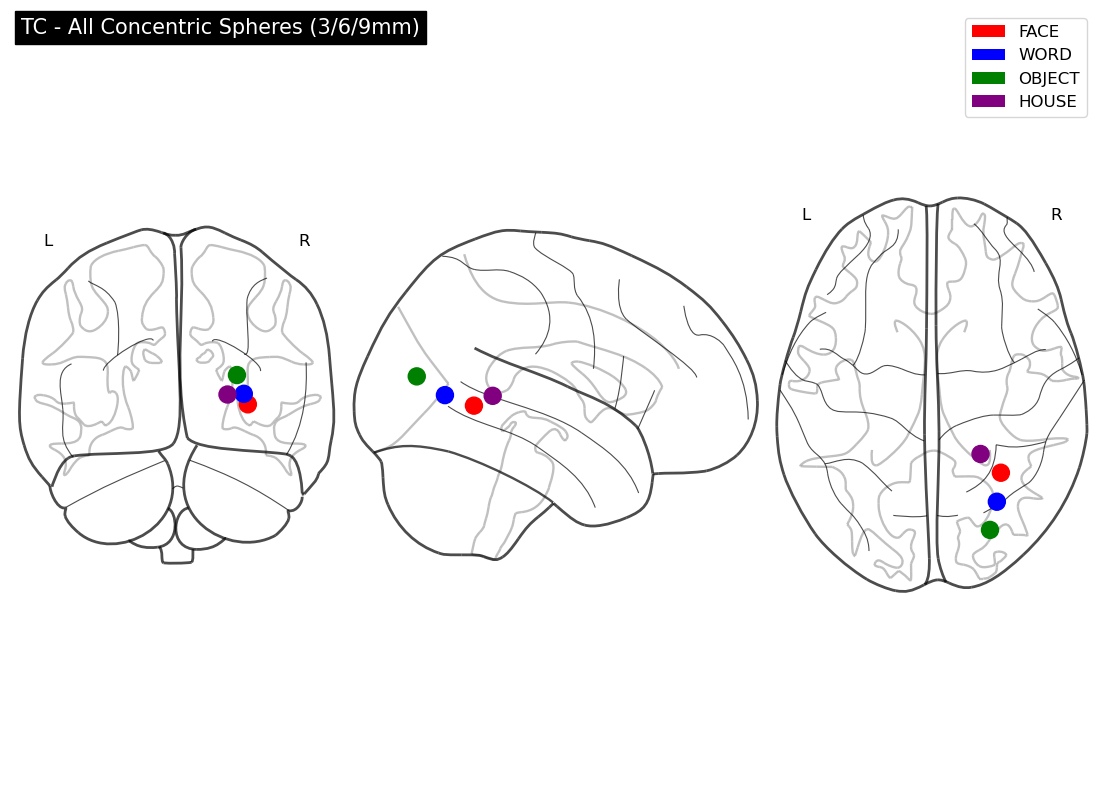

In [29]:
# CELL: Visualize all spheres on single brain per subject
def visualize_all_spheres(subject_id, sphere_results):
    """All concentric spheres on one glass brain"""
    code = SUBJECTS[subject_id]['code']
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    all_peaks = []
    all_colors = []
    all_sizes = []
    
    color_map = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    for cat in ['face', 'word', 'object', 'house']:
        if cat not in sphere_results[subject_id]:
            continue
        
        peak = sphere_results[subject_id][cat]['peak']
        
        # Add 3 concentric spheres
        for r, size in [(3, 50), (6, 100), (9, 150)]:
            all_peaks.append(peak)
            all_colors.append(color_map[cat])
            all_sizes.append(size)
    
    if len(all_peaks) == 0:
        return
    
    all_peaks = np.array(all_peaks)
    adjacency = np.zeros((len(all_peaks), len(all_peaks)))
    
    plotting.plot_connectome(adjacency, all_peaks,
                            node_color=all_colors, node_size=all_sizes,
                            axes=ax, colorbar=False,
                            title=f'{code} - All Concentric Spheres (3/6/9mm)')
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[cat], label=cat.upper())
                      for cat in ['face', 'word', 'object', 'house']
                      if cat in sphere_results[subject_id]]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.savefig(OUTPUT_DIR / f'{code}_all_spheres.png', dpi=300, bbox_inches='tight')
    plt.show()

for subj in ['sub-004', 'sub-021']:
    visualize_all_spheres(subj, golarai_spheres_final)